# APPM 5720 Biweekly Report - Part 3
### *Alexey Yermakov*
### *October 13, 2022*

# Summary
For this section, I use renset18 to do transfer learning to analyze the effectiveness of a variety of data augmentation techniques.

# Main Content
First, I load my dataset with batching and preprocessing (crop to 224x224x3 and normalize). Please refer to part 1 of this biweekly report for details.

In [1]:
# Make sure Torch is installed and our GPU is available
import torch
import numpy as np
from torch import permute, nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as TF
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time

# Print matplotlibe plots inline
%matplotlib inline

# Check if GPU is available, though I don't use it in this notebook
print("GPU Available?",torch.cuda.is_available())
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

GPU Available? True


In [2]:
# Load resnet18 dataset only, we won't be plotting images in this notebook
data_dir = '/home/alexey/Datasets/kaggle/cats_vs_dogs_parsed'
batch_size = 32
shuffle = True

# Transform from image to tensor and scale to [224,224]
transform_from_im = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def f_resnet18(im):
    return transform_from_im(im)
    
# Load our dataset from disk
train_data = datasets.ImageFolder(
    root=data_dir+'/train',
    transform=f_resnet18
)

val_data = datasets.ImageFolder(
    root=data_dir+'/train',
    transform=f_resnet18
)

# Make a dataloader for easy shuffling and batching
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
test_dl = DataLoader(val_data, batch_size=batch_size, shuffle=shuffle)

# Step 3: Make a wrapper so we push our data to GPU for each batch
def preprocess(x, y):
    return x.to(device), y.to(device)

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            # *b makes it so that the input to func is two variables: the images and the labels
            # yield is like return except it stops execution until the object is "grabbed"
            yield (self.func(*b)) 

train_dl_2 = WrappedDataLoader(train_dl, preprocess)
test_dl_2 = WrappedDataLoader(test_dl, preprocess)

For this next part, I load resnet18 with pretrained weights and make it possible to train it on the new dataset. See part 1 of this report for details. Here, I also save the model so that we can load it from its default state throughout the rest of the notebook.

In [3]:
# Load resnet18 with weights and make only the last layer trainable
rn18 = models.resnet18(weights = models.ResNet18_Weights.DEFAULT).to(device)

for param in rn18.parameters():
    param.requires_grad = False

for param in rn18.fc.parameters():
    param.requires_grad = True

# Set rn18 to training mode and make it a 2-class classifier
in_ftrs = 512 # from `rn18.fc.in_features`
out_ftrs = 2
rn18.fc = nn.Linear(in_ftrs, out_ftrs)
rn18.train()
rn18.to(device)

# Save model initial state
save_dir = '/home/alexey/School/APPM 5720/Biweekly/Oct13/Model/model_weights.pth'
torch.save(rn18.state_dict(), save_dir)

Lets define a helper function to load the original state of the model for testing purposes.

In [4]:
def reset_model(rn18):
    # Load default model weights
    rn18.load_state_dict(torch.load(save_dir))
    
    # Freeze all except the last layer
    for param in rn18.parameters():
        param.requires_grad = False

    for param in rn18.fc.parameters():
        param.requires_grad = True
    
    # Make sure model is on the GPU
    rn18.to(device)
        
reset_model(rn18)

Lets now bring over our training and validation loops as well as the loss function and optimizer from part 1 of this report.

In [5]:
# Define the training and validation loop
def train_loop(dataloader, model, loss_fn, optimizer, prints=False):
    size = len(dataloader)*batch_size
    if prints:
        print("Processing", len(dataloader), "batches of size", batch_size, "images")
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if prints and ((batch % (len(dataloader)//10) == 0) or (batch == len(dataloader))):
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}, {current/size*100:>2.0f}%]")

def val_loop(dataloader, model, loss_fn, type_str, prints=False):
    size = len(dataloader)*batch_size
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    
    if prints:
        print(f"{type_str} Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    
    return 100*correct

# Define our loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.NAdam(rn18.parameters())

Lets train the model as-is to get a baseline of the performance!

In [6]:
# Run training and validation
def train_model(rn18, prints = False, epochs=25):
    reset_model(rn18)
    
    if prints:
        print("Getting initial accuracies")
    train_acc = [val_loop(train_dl_2, rn18, loss_fn, "Training", prints)]
    val_acc = [val_loop(test_dl_2, rn18, loss_fn, "Testing",  prints)]
    
    t0 = time.time()
    for t in range(epochs):
        if prints:
            print(f"Epoch {t+1}\n----------------------------------------")
        t1 = time.time()
        train_loop(train_dl_2, rn18, loss_fn, optimizer, prints)
        t2 = time.time()
        train_acc.append(val_loop(train_dl_2, rn18, loss_fn, "Training", prints))
        val_acc.append(val_loop(test_dl_2, rn18, loss_fn, "Testing",  prints))
        t3 = time.time()
        
        if prints:
            print()
            print(f"Training time: {t2-t1:.2f}s")
            print(f"Accuracy time: {t3-t2:.2f}s")
            print(f"Epoch time: {t3-t1:.2f}s")
            print()
    tf = time.time()
    if prints:
        print("Done!")
        print(f"Total time: {tf-t0:.2f}s")
        
    return train_acc, val_acc

train_acc, val_acc = train_model(rn18, True)

Getting initial accuracies
Training Error: 
 Accuracy: 58.4%, Avg loss: 0.671477
Testing Error: 
 Accuracy: 58.1%, Avg loss: 0.672603
Epoch 1
----------------------------------------
Processing 222 batches of size 32 images
loss: 0.637370  [    0/ 7104,  0%]
loss: 0.322904  [  704/ 7104, 10%]
loss: 0.039190  [ 1408/ 7104, 20%]
loss: 0.113988  [ 2112/ 7104, 30%]
loss: 0.098017  [ 2816/ 7104, 40%]
loss: 0.055342  [ 3520/ 7104, 50%]
loss: 0.161761  [ 4224/ 7104, 59%]
loss: 0.041256  [ 4928/ 7104, 69%]
loss: 0.166033  [ 5632/ 7104, 79%]
loss: 0.183199  [ 6336/ 7104, 89%]
loss: 0.047802  [ 7040/ 7104, 99%]
Training Error: 
 Accuracy: 94.5%, Avg loss: 0.133788
Testing Error: 
 Accuracy: 94.7%, Avg loss: 0.131308

Training time: 24.50s
Accuracy time: 55.07s
Epoch time: 79.57s

Epoch 2
----------------------------------------
Processing 222 batches of size 32 images
loss: 0.039899  [    0/ 7104,  0%]
loss: 0.081495  [  704/ 7104, 10%]
loss: 0.124951  [ 1408/ 7104, 20%]
loss: 0.082139  [ 2112/ 

loss: 0.133014  [ 4224/ 7104, 59%]
loss: 0.127650  [ 4928/ 7104, 69%]
loss: 0.009221  [ 5632/ 7104, 79%]
loss: 0.089060  [ 6336/ 7104, 89%]
loss: 0.248900  [ 7040/ 7104, 99%]
Training Error: 
 Accuracy: 97.8%, Avg loss: 0.052658
Testing Error: 
 Accuracy: 97.8%, Avg loss: 0.056193

Training time: 23.28s
Accuracy time: 55.13s
Epoch time: 78.41s

Epoch 14
----------------------------------------
Processing 222 batches of size 32 images
loss: 0.006697  [    0/ 7104,  0%]
loss: 0.123921  [  704/ 7104, 10%]
loss: 0.018555  [ 1408/ 7104, 20%]
loss: 0.024214  [ 2112/ 7104, 30%]
loss: 0.013747  [ 2816/ 7104, 40%]
loss: 0.249447  [ 3520/ 7104, 50%]
loss: 0.085835  [ 4224/ 7104, 59%]
loss: 0.025810  [ 4928/ 7104, 69%]
loss: 0.018009  [ 5632/ 7104, 79%]
loss: 0.019923  [ 6336/ 7104, 89%]
loss: 0.061300  [ 7040/ 7104, 99%]
Training Error: 
 Accuracy: 97.6%, Avg loss: 0.052842
Testing Error: 
 Accuracy: 98.1%, Avg loss: 0.050425

Training time: 23.30s
Accuracy time: 54.68s
Epoch time: 77.98s

Epoch

Great! this is similar to the results we saw in part 1 of the report.
Lets define a helper function to plot our training and validation accuracy as a function of epochs.

In [7]:
def plot_train_test_acc(train_acc, test_acc):
    fig, ax = plt.subplots(1,1,figsize=(5,5), dpi=120, facecolor='white', tight_layout={'pad': 1})

    marker_style = dict(markersize = 6)

    ax.plot(list(range(0, len(train_acc))), train_acc, linestyle='solid', marker='^', color='#d95319', label="Training Accuracy", **marker_style)
    ax.plot(list(range(0, len(test_acc))), test_acc, linestyle='solid', marker='^', color='#0072bd', label="Testing Accuracy", **marker_style)

    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy %')
    
    ax.xaxis.get_major_locator().set_params(integer=True)

    ax.legend(fontsize='small')

    plt.show()
    
    max_train_epoch = np.argmax(np.asarray(train_acc))
    max_train_acc = train_acc[max_train_epoch]
    
    max_test_epoch = np.argmax(np.asarray(test_acc))
    max_test_acc = test_acc[max_test_epoch]
    
    print(f"Max training accuracy {max_train_acc:.2f}%, at epoch {max_train_epoch}")
    print(f"Max testing accuracy {max_test_acc:.2f}%, at epoch {max_test_epoch}")

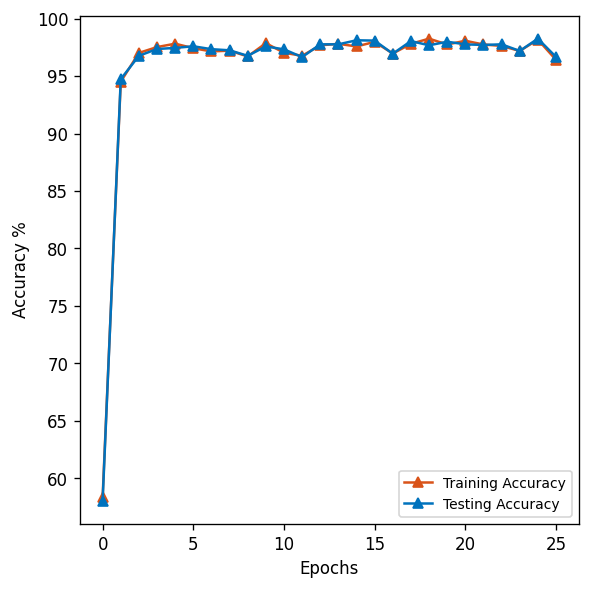

Max training accuracy 98.25%, at epoch 18
Max testing accuracy 98.25%, at epoch 24


In [8]:
plot_train_test_acc(train_acc, val_acc)

It's now time to test our model with various data augmentation techniques! I'll try different techniques and summarize the results in a table at the bottom of the report.

Let start with randomly flipping our data horizontally. This should help since we expect our testing data to not be flipped vertically (though in a real world scenario we might encounter such data).

(Excuse the unnecessary print statements, I forgot to remove the print before I ran everything and don't want to re-run everything since it takes a while...)

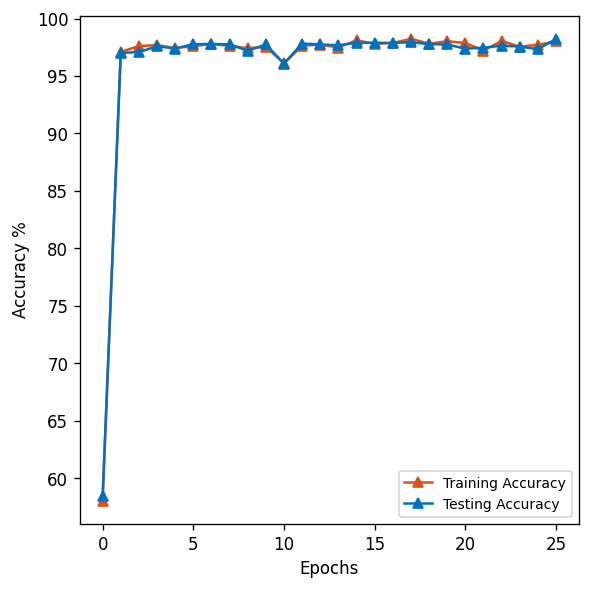

Max training accuracy 98.24%, at epoch 17
Max testing accuracy 98.21%, at epoch 25


In [9]:
# Probability for any transformation to happen
p = 0.3

# Define our new transformation
transform_from_im = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def f_resnet18(im):
    tmp = im
    if (np.random.rand() < p):
        tmp = TF.hflip(tmp) # NEW TRANSFORMATION
    return transform_from_im(tmp)

# Train the model
train_acc, val_acc = train_model(rn18)

# Plot results
plot_train_test_acc(train_acc, val_acc)

Lets try random erasing! I implemented this method on my own in part 2 of this report, but I'll use pytorch's implementation for simplicity.

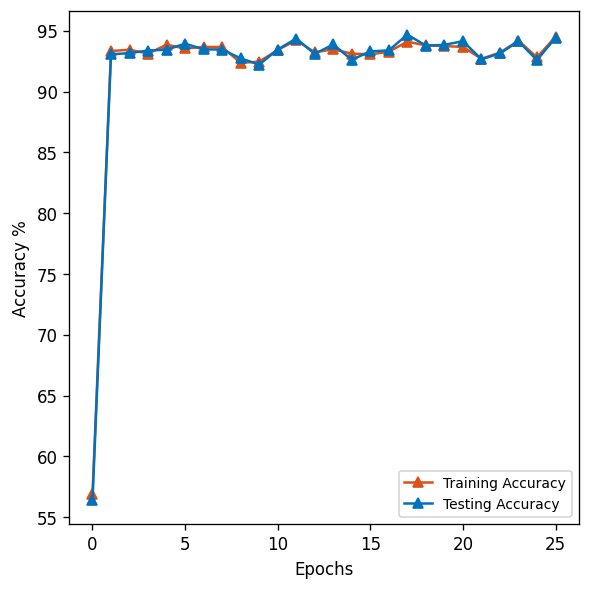

Max training accuracy 94.51%, at epoch 25
Max testing accuracy 94.68%, at epoch 17


In [10]:
# Parameters for random erase
sl = 0.2 # Minimum ratio of area erased
sh = 0.3 # Maximum ratio of area erased
r1 = 0.6 # Aspect ratio min
r2 = 1.4 # Aspect ratio max

# Probability for any transformation to happen
p = 0.3

# Define our new transformation
transform_from_im = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.RandomErasing(p, scale=(sl, sh), ratio=(r1, r2), value='random'), # NEW TRANSFORMATION
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def f_resnet18(im):
    return transform_from_im(tmp)

# Train the model
train_acc, val_acc = train_model(rn18)

# Plot results
plot_train_test_acc(train_acc, val_acc)

Lets combine the two `:)`

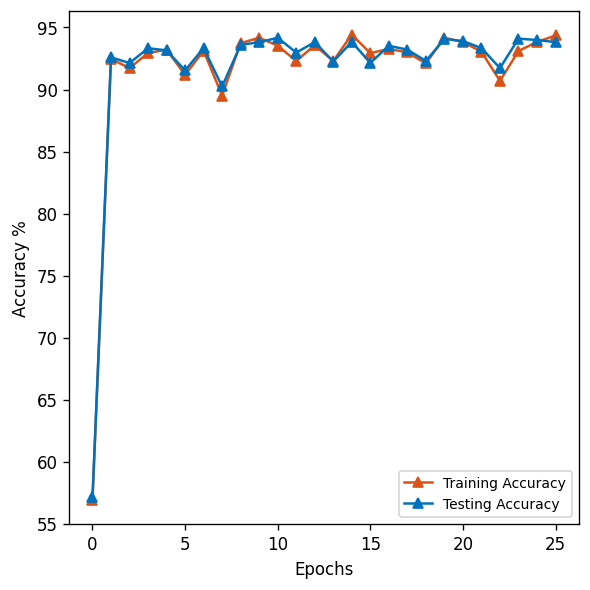

Max training accuracy 94.43%, at epoch 14
Max testing accuracy 94.17%, at epoch 10


In [11]:
# Parameters for random erase
sl = 0.2 # Minimum ratio of area erased
sh = 0.3 # Maximum ratio of area erased
r1 = 0.6 # Aspect ratio min
r2 = 1.4 # Aspect ratio max

# Probability for any transformation to happen
p = 0.3

# Define our new transformation
transform_from_im = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.RandomErasing(p, scale=(sl, sh), ratio=(r1, r2), value='random'), # NEW TRANSFORMATION
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def f_resnet18(im):
    tmp = im
    if (np.random.rand() < p):
        tmp = TF.hflip(tmp) # NEW TRANSFORMATION
    return transform_from_im(tmp)

# Train the model
train_acc, val_acc = train_model(rn18)

# Plot results
plot_train_test_acc(train_acc, val_acc)

Okay, now lets go crazy. Lets add many transformations and see how this affects out model. See [here](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py) and [here](https://pytorch.org/vision/stable/transforms.html) for how they work.

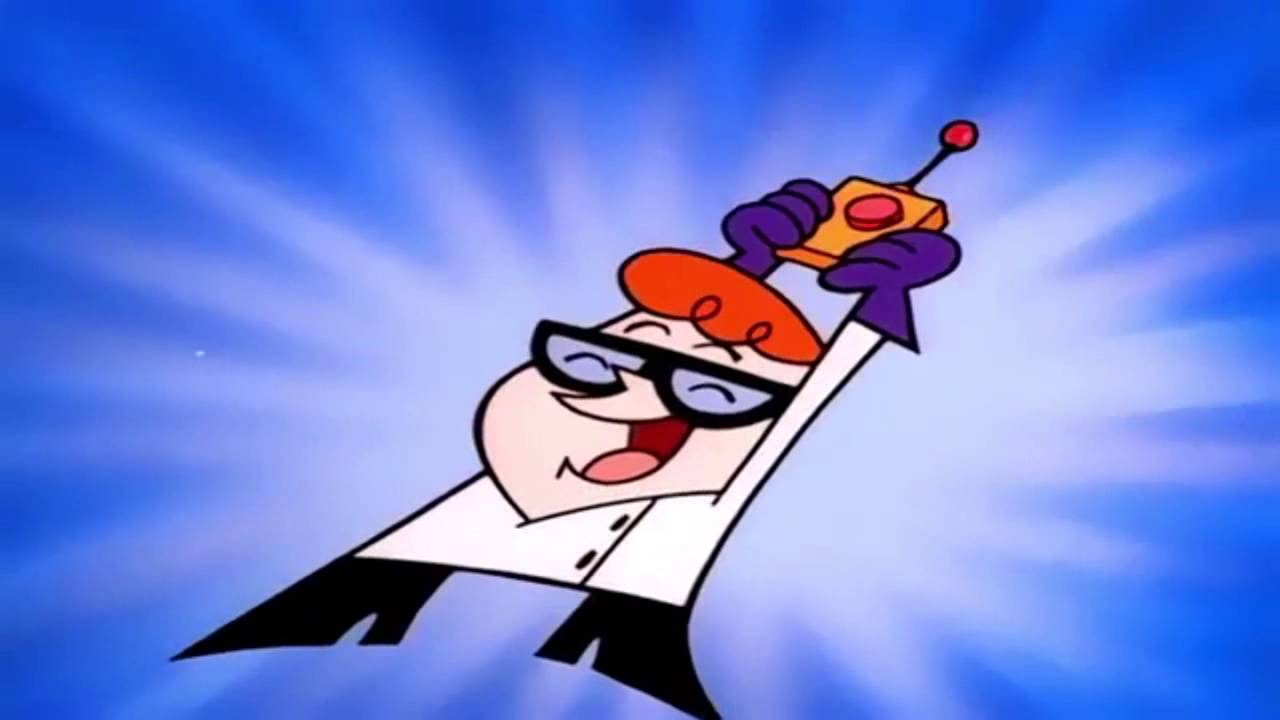

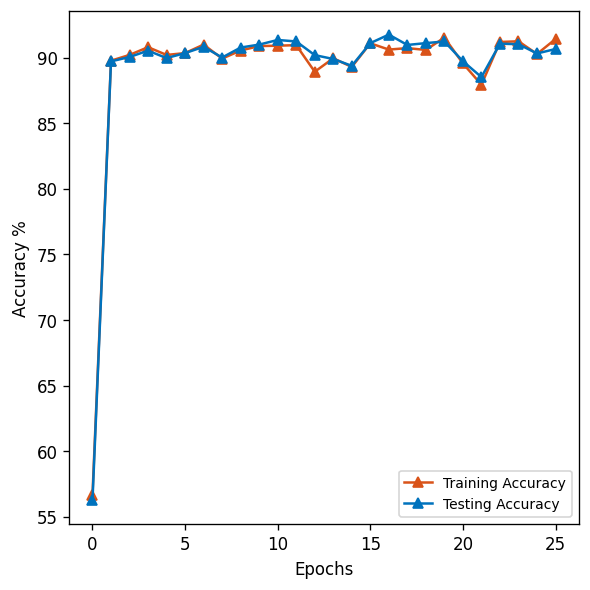

Max training accuracy 91.53%, at epoch 19
Max testing accuracy 91.75%, at epoch 16


In [12]:
# Parameters for random erase
sl = 0.2 # Minimum ratio of area erased
sh = 0.3 # Maximum ratio of area erased
r1 = 0.6 # Aspect ratio min
r2 = 1.4 # Aspect ratio max

# Probability for any transformation to happen
p = 0.3

# Define our new transformation
transform_from_im = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.RandomErasing(p, scale=(sl, sh), ratio=(r1, r2), value='random'), # NEW TRANSFORMATION
    transforms.RandomRotation(15), # NEW TRANSFORMATION
    transforms.RandomPerspective(distortion_scale=0.6, p=p), # NEW TRANSFORMATION
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def f_resnet18(im):
    tmp = im
    if (np.random.rand() < p):
        tmp = TF.hflip(tmp) # NEW TRANSFORMATION
    if (np.random.rand() < p):
        tmp = TF.vflip(tmp) # NEW TRANSFORMATION
    return transform_from_im(tmp)

# Train the model
train_acc, val_acc = train_model(rn18)

# Plot results
plot_train_test_acc(train_acc, val_acc)

Below is a table summarizing the results!

<table>
   <tr>
       <th>Data Augmentation Method(s)</th>
       <th>Max training accuracy</th>
       <th>Max testing accuracy</th>
   </tr>
   <tr>
       <td>None</td>
       <td>98.25%</td>
       <td>98.25%</td>
   </tr>
   <tr>
       <td>Horizontal Flip</td>
       <td>98.25%</td>
       <td>98.21%</td>
   </tr>
   <tr>
       <td>Random Erasing</td>
       <td>94.51%</td>
       <td>94.68%</td>
   </tr>
   <tr>
       <td>Random Erasing and Horizontal Flip</td>
       <td>94.43%</td>
       <td>94.17%</td>
   </tr>
   <tr>
       <td>Random Erasing, Horizontal Flip, Random Rotation, Random Perspective, Vertical Flip</td>
       <td>91.53%</td>
       <td>91.75%</td>
   </tr>
</table>

These results are frankly underwhelming. The best method is clearly no data augmentation and as we introduce different data augmentation the performance goes down. There are a few possible explanations for this behavior:

1. Since our dataset is small and has two classes, data augmentation doesn't help much.
2. Since we're only training a single densely connected layer, the regularization that comes with data augmentation is hurting our performance (recall that we froze all the layers of resnet18 except for the last layer).

As such, possible directions for future exploration are:

1. Try this method with a larger dataset with more classes.
2. Try this method without freezing the layers of resnet18.
3. Instead of checking for accuracy, check for when the model has minimum loss.
4. Try all of the above methods.

A clear downside of the above methods would be that testing and obtaining results will take much, much longer! In this report I used 25 epochs since it's clear I don't need much more to get better accuracy.

I may explore these options in future reports!